# Noise Conditional Score Networks (NCSN)
## Multi-Scale Score Matching for Generative Modeling

This notebook introduces **Noise Conditional Score Networks (NCSN)**, which solve the fundamental limitation of single-noise denoising score matching by using **multiple noise levels** with a **noise-conditional score network**.



## 1. Why Multi-Scale? The Single-Noise Dilemma

### Recap: The Problem with Single-Noise DSM

In single-noise denoising score matching, we face a fundamental trade-off:

| Small σ | Large σ |
|---------|----------|
| Accurate score near data | Score defined everywhere |
| Undefined far from data | Blurs fine structure |
| Langevin gets stuck | Poor sample quality |

### The Multi-Scale Solution

**Key Insight:** Use a *sequence* of decreasing noise levels:

$$\sigma_1 > \sigma_2 > \ldots > \sigma_L$$

- **Large σ (early):** Provides global structure, guides from anywhere
- **Small σ (late):** Refines local details, sharpens samples

### Annealed Langevin Dynamics

Instead of sampling at a single noise level, we **anneal** through the sequence:

```
Start with noise x ~ N(0, σ₁²I)
For σ in [σ₁, σ₂, ..., σ_L]:  # large to small
    Run Langevin dynamics using s_θ(x, σ)
Return final x
```

This is analogous to **simulated annealing** in optimization!

## 2. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

Using device: cpu


## 3. The Noise Schedule

### Geometric Noise Schedule

NCSN uses a **geometric sequence** of noise levels:

$$\sigma_i = \sigma_1 \cdot \left( \frac{\sigma_L}{\sigma_1} \right)^{\frac{i-1}{L-1}}$$

This ensures:
- Even spacing in log-scale
- Smooth transition between scales
- Each level roughly halves the previous (with appropriate L)

### Choosing σ₁ and σ_L

- **σ₁ (largest):** Should cover the data range. Rule of thumb: σ₁ ≈ max pairwise distance in data
- **σ_L (smallest):** Should be small enough to preserve detail, but not too small. Rule of thumb: σ_L ≈ 0.01

Noise Schedule (geometric):
  L = 10 levels
  σ_max = 1.0, σ_min = 0.01
  Sigmas: [1.     0.5995 0.3594 0.2154 0.1292 0.0774 0.0464 0.0278 0.0167 0.01  ]
  Ratio between consecutive levels: 1.668


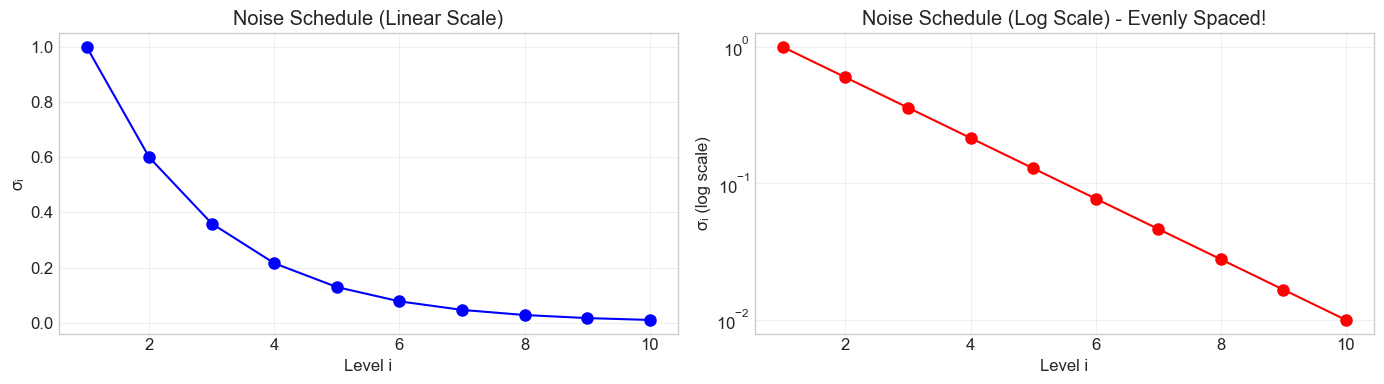

In [2]:
def geometric_noise_schedule(sigma_min, sigma_max, L):
    """
    Create a geometric noise schedule.
    
    Args:
        sigma_min: Smallest noise level (σ_L)
        sigma_max: Largest noise level (σ_1)
        L: Number of noise levels
    
    Returns:
        sigmas: Tensor of shape (L,) with σ_1 > σ_2 > ... > σ_L
    """
    # Geometric sequence from sigma_max to sigma_min
    sigmas = torch.exp(
        torch.linspace(np.log(sigma_max), np.log(sigma_min), L)
    )
    return sigmas


# Example schedule
L = 10  # Number of noise levels
sigma_max = 1.0
sigma_min = 0.01

sigmas = geometric_noise_schedule(sigma_min, sigma_max, L)

print("Noise Schedule (geometric):")
print(f"  L = {L} levels")
print(f"  σ_max = {sigma_max}, σ_min = {sigma_min}")
print(f"  Sigmas: {sigmas.numpy().round(4)}")
print(f"  Ratio between consecutive levels: {(sigmas[:-1] / sigmas[1:]).mean():.3f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Linear scale
axes[0].plot(range(1, L+1), sigmas.numpy(), 'bo-', markersize=8)
axes[0].set_xlabel('Level i')
axes[0].set_ylabel('σᵢ')
axes[0].set_title('Noise Schedule (Linear Scale)')
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].semilogy(range(1, L+1), sigmas.numpy(), 'ro-', markersize=8)
axes[1].set_xlabel('Level i')
axes[1].set_ylabel('σᵢ (log scale)')
axes[1].set_title('Noise Schedule (Log Scale) - Evenly Spaced!')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Toy Dataset and Visualization at Multiple Noise Levels

Dataset shape: (10000, 2)
Data range: x=[-1.105, 1.393], y=[-1.278, 1.529]


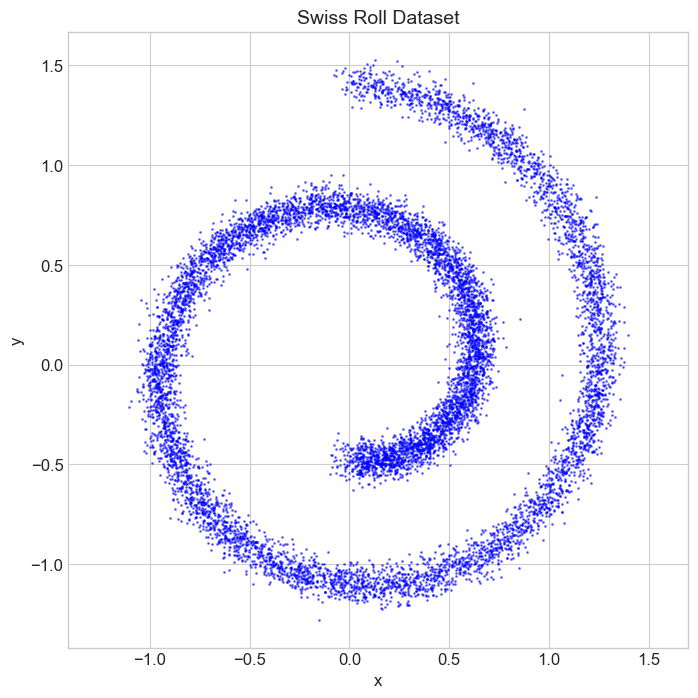

In [3]:
from sklearn.datasets import make_swiss_roll

def generate_swiss_roll_data(n_samples=10000, noise=0.5):
    """
    Generate a 2D Swiss roll dataset using sklearn.
    """
    X, _ = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=42)
    X = X[:, [0, 2]]  # Use X and Z coordinates for 2D
    X = X / 10.0  # Normalize to reasonable range
    return X.astype(np.float32)


# Generate data
X_train = generate_swiss_roll_data(n_samples=10000, noise=0.5)
X_tensor = torch.from_numpy(X_train).to(device)

print(f"Dataset shape: {X_train.shape}")
print(f"Data range: x=[{X_train[:, 0].min():.3f}, {X_train[:, 0].max():.3f}], y=[{X_train[:, 1].min():.3f}, {X_train[:, 1].max():.3f}]")

# Visualize
plt.figure(figsize=(8, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], s=1, alpha=0.5, c='blue')
plt.title('Swiss Roll Dataset', fontsize=14)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

/var/folders/hf/hwg72r856z362qcrv_4q2xp00000gn/T/ipykernel_53656/3411486024.py:18: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/Users/oualid/miniconda3/envs/dl_finance/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


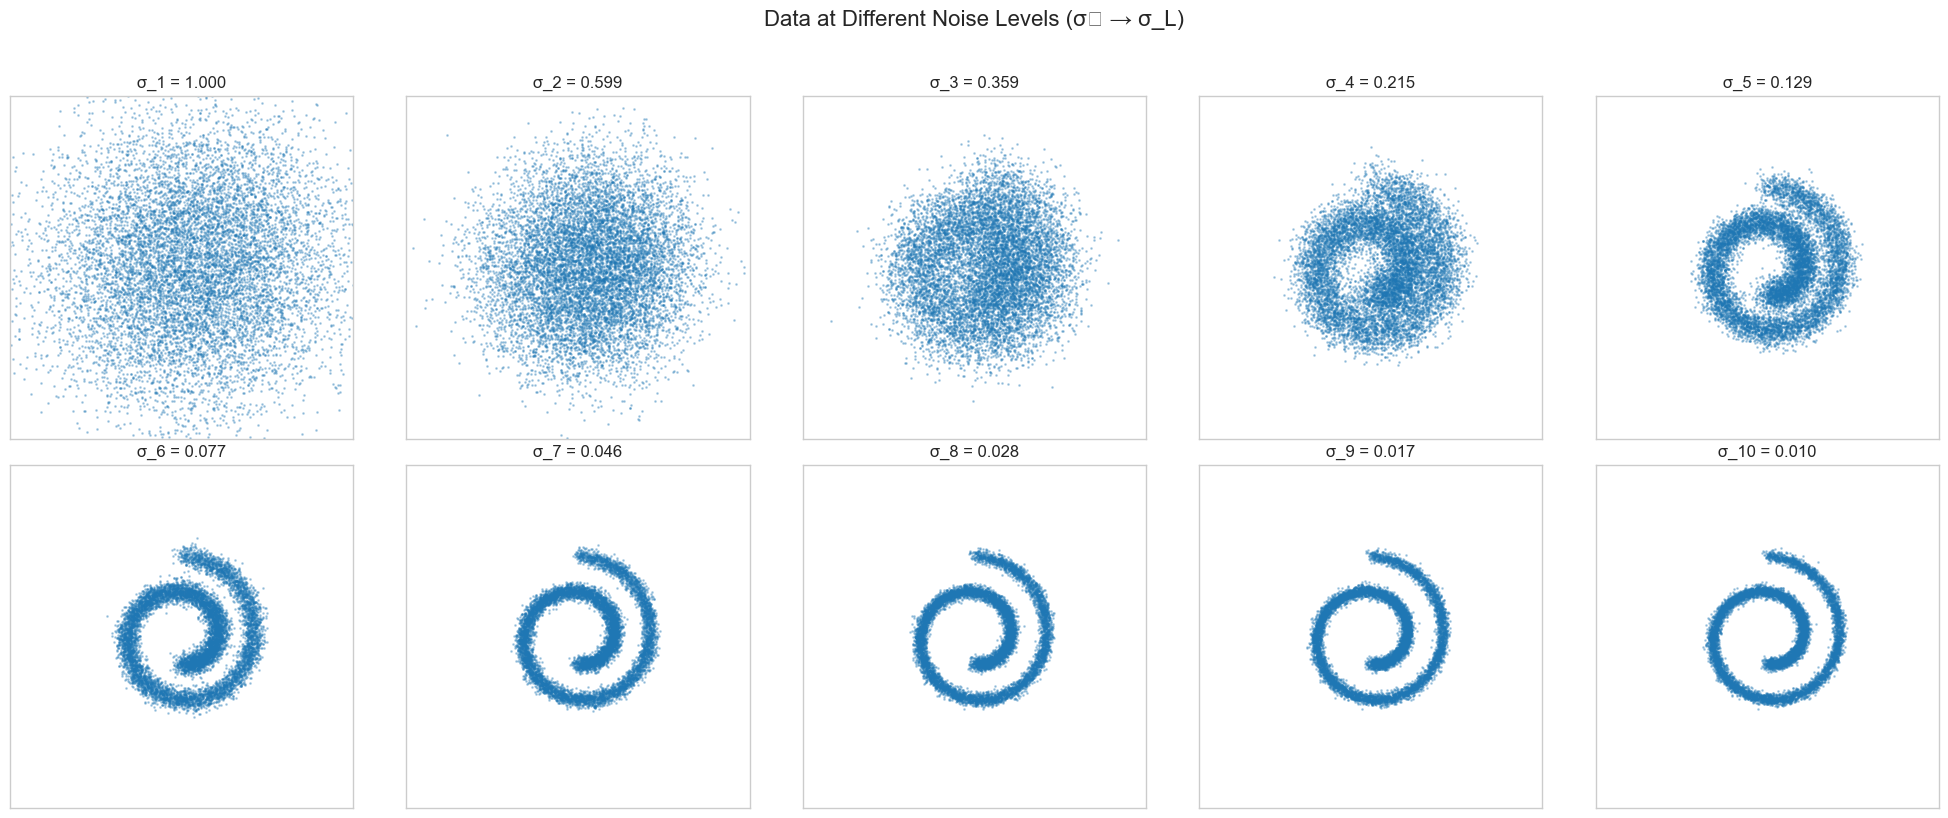

Observation: Large σ destroys structure, small σ preserves it.
NCSN learns to denoise at ALL these scales!


In [4]:
# Visualize data at different noise levels
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, sigma in enumerate(sigmas):
    # Add noise
    noisy_data = X_train + sigma.item() * np.random.randn(*X_train.shape)
    
    axes[idx].scatter(noisy_data[:, 0], noisy_data[:, 1], s=1, alpha=0.3)
    axes[idx].set_title(f'σ_{idx+1} = {sigma.item():.3f}', fontsize=12)
    axes[idx].set_xlim(-3, 3)
    axes[idx].set_ylim(-3, 3)
    axes[idx].set_aspect('equal')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

plt.suptitle('Data at Different Noise Levels (σ₁ → σ_L)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("Observation: Large σ destroys structure, small σ preserves it.")
print("NCSN learns to denoise at ALL these scales!")

## 5. Noise-Conditional Score Network Architecture

### Key Difference from Single-Noise DSM

The network must now take the **noise level σ** as an additional input:

$$s_\theta(x, \sigma) \approx \nabla_x \log p_\sigma(x)$$

### Conditioning Approaches

1. **Simple concatenation:** Append σ or log(σ) to input
2. **Embedding:** Use sinusoidal embedding (like positional encoding)
3. **FiLM conditioning:** Affine transformation of hidden layers

We'll use **sinusoidal embedding** for better expressiveness.

### Output Scaling

An important trick: the score magnitude scales as 1/σ, so we can:
- Have the network output a "normalized" score
- Multiply by 1/σ at the end

This stabilizes training across noise levels.

In [5]:
# For the simple NCSN architecture, we directly concatenate sigma to the input
# This is simpler and works well for 2D toy data

# Let's visualize how different sigma values look when concatenated
print("Simple Sigma Conditioning:")
print("Instead of complex sinusoidal embeddings, we simply concatenate σ to the input.")
print("Input to network: [x₁, x₂, σ] → Output: [score₁, score₂]")
print()
print("This works well for toy data and is easier to understand.")
print("For more complex data (images), sinusoidal embeddings help capture periodicity.")

Simple Sigma Conditioning:
Instead of complex sinusoidal embeddings, we simply concatenate σ to the input.
Input to network: [x₁, x₂, σ] → Output: [score₁, score₂]

This works well for toy data and is easier to understand.
For more complex data (images), sinusoidal embeddings help capture periodicity.


In [6]:
class NCSN(nn.Module):
    """
    Noise Conditional Score Network.
    
    Simple architecture that concatenates sigma directly to the input.
    This is the approach from Song & Ermon (2019).
    
    Architecture:
    - Input: [x, σ] concatenated
    - Hidden layers with ReLU activations
    - Output: score (same dimension as x)
    """
    def __init__(self, data_dim=2, hidden_dim=128):
        super(NCSN, self).__init__()
        
        # Input: data_dim + 1 (for sigma)
        self.net = nn.Sequential(
            nn.Linear(data_dim + 1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, data_dim)
        )
    
    def forward(self, x, sigma):
        """
        Args:
            x: Noisy data, shape (batch, data_dim)
            sigma: Noise levels, shape (batch,) or (batch, 1)
        Returns:
            score: Estimated score, shape (batch, data_dim)
        """
        # Ensure sigma has correct shape
        if sigma.dim() == 1:
            sigma = sigma.unsqueeze(1)
        
        # Concatenate x and sigma
        inp = torch.cat([x, sigma], dim=1)
        
        return self.net(inp)


# Create model
model = NCSN(data_dim=2, hidden_dim=128).to(device)

print(f"NCSN parameters: {sum(p.numel() for p in model.parameters()):,}")
print(model)

NCSN parameters: 50,306
NCSN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=2, bias=True)
  )
)


## 6. Training Objective: Multi-Scale DSM

### Loss Function

For each noise level σ, the DSM loss is:

$$\mathcal{L}(\theta; \sigma) = \mathbb{E}_{x_0, \epsilon} \left[ \left\| s_\theta(x_0 + \sigma\epsilon, \sigma) + \frac{\epsilon}{\sigma} \right\|^2 \right]$$

### Weighted Combination

The total loss combines all noise levels:

$$\mathcal{L}(\theta) = \sum_{i=1}^{L} \lambda(\sigma_i) \, \mathcal{L}(\theta; \sigma_i)$$

### Weighting Strategies

1. **Uniform:** $\lambda(\sigma) = 1$
   - Simple but may focus too much on small σ

2. **σ²-weighting:** $\lambda(\sigma) = \sigma^2$
   - Song & Ermon's recommendation
   - Balances gradient magnitudes across scales
   - With 1/σ output scaling, this becomes: $\mathbb{E}[\|\sigma \cdot s_\theta + \epsilon\|^2]$

We'll use **σ²-weighting** as it provides more stable training.

In [7]:
def train_ncsn(model, data, sigmas, epochs=100, batch_size=128, lr=1e-3, device='cpu'):
    """
    Train NCSN using multi-scale denoising score matching with σ²-weighted loss.
    
    The σ²-weighting ensures balanced gradient contributions across all noise levels.
    Without it, small σ values dominate the loss (since target ~ 1/σ²).
    
    We track the UNWEIGHTED loss for visualization (shows learning progress),
    but use WEIGHTED loss for backpropagation (balances gradients).
    
    Args:
        model: NCSN model
        data: Training data, numpy array of shape (n, dim)
        sigmas: Noise levels, tensor of shape (L,)
        epochs: Number of training epochs
        batch_size: Batch size
        lr: Learning rate
        device: Device to train on
    
    Returns:
        losses: List of epoch losses (unweighted, for visualization)
    """
    dataset = TensorDataset(torch.from_numpy(data))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    sigmas = sigmas.to(device)
    
    losses = []
    
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for (x,) in dataloader:
            x = x.to(device)
            batch_size_actual = x.shape[0]
            
            # Sample random noise levels for each data point
            sigma_idx = torch.randint(0, len(sigmas), (batch_size_actual,), device=device)
            sigma = sigmas[sigma_idx]
            
            # Add Gaussian noise with standard deviation = sigma
            noise = torch.randn_like(x) * sigma.unsqueeze(1)
            x_noisy = x + noise
            
            # Predict score
            pred_score = model(x_noisy, sigma)
            
            # Target score: -noise / sigma²
            target_score = -noise / (sigma.unsqueeze(1) ** 2)
            
            # Compute per-sample loss
            loss_per_sample = ((pred_score - target_score) ** 2).sum(dim=1)
            
            # σ²-weighted loss for backpropagation (balances gradients)
            weighted_loss = (sigma ** 2) * loss_per_sample
            loss_for_backward = weighted_loss.mean()
            
            # Unweighted loss for tracking (shows learning progress)
            unweighted_loss = loss_per_sample.mean()
            
            optimizer.zero_grad()
            loss_for_backward.backward()
            optimizer.step()
            
            epoch_loss += unweighted_loss.item()
            num_batches += 1
        
        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)
        
        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | Loss: {avg_loss:.4f}")
    
    return losses


# Define noise schedule for training
# Using fixed levels like the legacy implementation
noise_levels = [1.0, 0.5, 0.25, 0.1, 0.05, 0.02, 0.01]
sigmas = torch.tensor(noise_levels, dtype=torch.float32)
L = len(sigmas)

print(f"Training NCSN with L={L} noise levels...")
print(f"Sigmas: {sigmas.numpy()}\n")

losses = train_ncsn(
    model, X_train, sigmas, 
    epochs=200, batch_size=128, lr=1e-3, device=device
)

Training NCSN with L=7 noise levels...
Sigmas: [1.   0.5  0.25 0.1  0.05 0.02 0.01]

Epoch   1/200 | Loss: 3734.4260
Epoch  20/200 | Loss: 3716.4315
Epoch  40/200 | Loss: 3721.6458
Epoch  60/200 | Loss: 3798.3892
Epoch  80/200 | Loss: 3714.2460
Epoch 100/200 | Loss: 3610.5423
Epoch 120/200 | Loss: 3583.8972
Epoch 140/200 | Loss: 3694.1041
Epoch 160/200 | Loss: 3474.8821
Epoch 180/200 | Loss: 3572.8542
Epoch 200/200 | Loss: 3552.8107


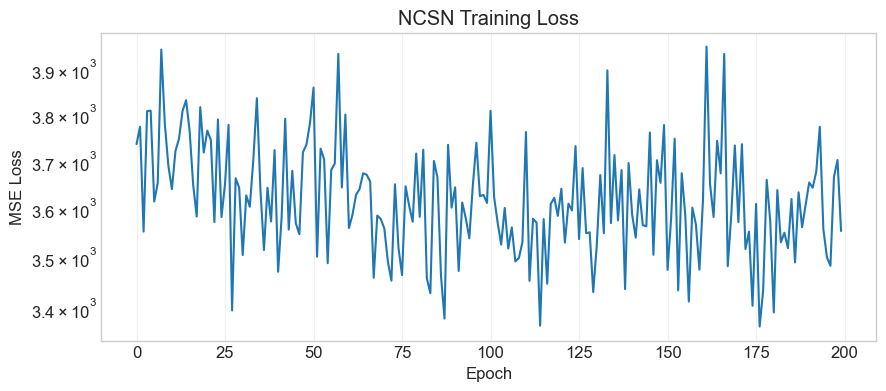

In [8]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('NCSN Training Loss')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

## 7. Visualizing Learned Scores at Different Noise Levels

A key insight: the score field looks different at each noise level!
- **Large σ:** Broad, pointing toward data center
- **Small σ:** Sharp, pointing toward nearest data point

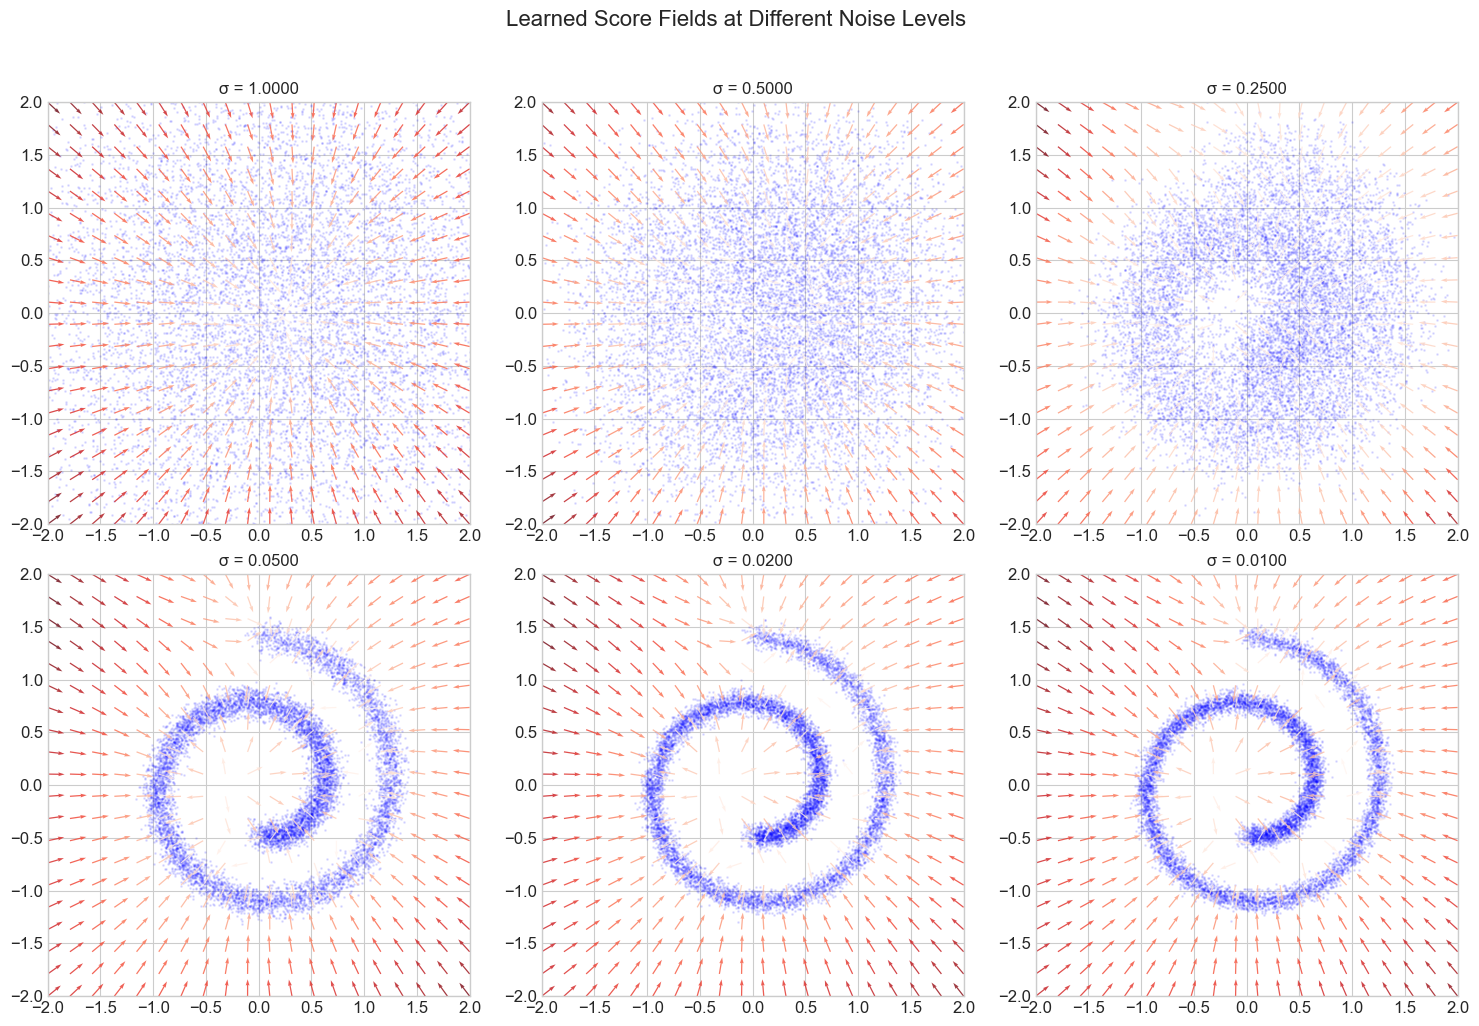

Observation:
- Large σ: Score field is smooth, provides global guidance
- Small σ: Score field is sharp, captures fine structure


In [9]:
@torch.no_grad()
def visualize_score_at_sigma(model, sigma, data, xlim=(-2, 2), ylim=(-2, 2), grid_size=20, device='cpu'):
    """
    Visualize the learned score field at a specific noise level.
    """
    model.eval()
    
    # Create grid
    x_range = np.linspace(xlim[0], xlim[1], grid_size)
    y_range = np.linspace(ylim[0], ylim[1], grid_size)
    X, Y = np.meshgrid(x_range, y_range)
    grid_points = np.stack([X.flatten(), Y.flatten()], axis=1).astype(np.float32)
    
    # Get scores
    grid_tensor = torch.from_numpy(grid_points).to(device)
    sigma_tensor = torch.full((grid_tensor.shape[0],), sigma, device=device)
    scores = model(grid_tensor, sigma_tensor).cpu().numpy()
    
    U = scores[:, 0].reshape(X.shape)
    V = scores[:, 1].reshape(X.shape)
    
    # Normalize for visualization
    magnitude = np.sqrt(U**2 + V**2)
    U_norm = U / (magnitude + 1e-6)
    V_norm = V / (magnitude + 1e-6)
    
    return X, Y, U_norm, V_norm, magnitude


# Visualize at multiple sigma levels
sigma_indices = [0, 1, 2, 4, 5, 6]  # Select 6 levels to show
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, sigma_idx in enumerate(sigma_indices):
    sigma = sigmas[sigma_idx].item()
    X_grid, Y_grid, U, V, mag = visualize_score_at_sigma(model, sigma, X_train, device=device)
    
    # Plot data (with noise at this level)
    noisy_data = X_train + sigma * np.random.randn(*X_train.shape)
    axes[idx].scatter(noisy_data[:, 0], noisy_data[:, 1], s=1, alpha=0.1, c='blue')
    
    # Plot score field
    quiver = axes[idx].quiver(X_grid, Y_grid, U, V, mag.flatten(), cmap='Reds', alpha=0.8, scale=25)
    
    axes[idx].set_title(f'σ = {sigma:.4f}', fontsize=12)
    axes[idx].set_xlim(-2, 2)
    axes[idx].set_ylim(-2, 2)
    axes[idx].set_aspect('equal')

plt.suptitle('Learned Score Fields at Different Noise Levels', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("Observation:")
print("- Large σ: Score field is smooth, provides global guidance")
print("- Small σ: Score field is sharp, captures fine structure")

## 8. Annealed Langevin Dynamics

The key sampling algorithm for NCSN:

```
Algorithm: Annealed Langevin Dynamics
────────────────────────────────────
Input: Score network s_θ(x, σ), noise levels {σ₁, ..., σ_L}, 
       steps per level T, step size ε

1. Initialize x ~ N(0, σ₁²I)
2. For i = 1, ..., L:
   a. αᵢ = ε · (σᵢ / σ_L)²    # Adaptive step size
   b. For t = 1, ..., T:
      x ← x + (αᵢ/2) · s_θ(x, σᵢ) + √αᵢ · z,  z ~ N(0, I)
3. Return x
```

### Adaptive Step Size

The step size $\alpha_i = \epsilon \cdot (\sigma_i / \sigma_L)^2$ ensures:
- Larger steps at high noise (faster exploration)
- Smaller steps at low noise (precise refinement)

In [10]:
@torch.no_grad()
def annealed_langevin_dynamics(model, sigmas, n_samples, steps_per_level=100, 
                                step_size_factor=0.1, return_trajectory=False, device='cpu'):
    """
    Sample using Annealed Langevin Dynamics.
    
    Args:
        model: Trained NCSN
        sigmas: Noise schedule (σ₁ > σ₂ > ... > σ_L), sorted descending
        n_samples: Number of samples to generate
        steps_per_level: Langevin steps per noise level
        step_size_factor: Multiplier for step size (step_size = factor * sigma²)
        return_trajectory: If True, return intermediate samples
        device: Device to run on
    
    Returns:
        samples: Final samples, shape (n_samples, 2)
        trajectory (optional): List of (samples, sigma) tuples
    """
    model.eval()
    
    # Sort sigmas in descending order (largest to smallest)
    sigmas_sorted, _ = torch.sort(sigmas, descending=True)
    sigmas_sorted = sigmas_sorted.to(device)
    
    # Initialize from Gaussian noise with std = sigma_max
    x = torch.randn(n_samples, 2, device=device) * sigmas_sorted[0]
    
    trajectory = [(x.cpu().numpy().copy(), 'init')] if return_trajectory else None
    
    # Anneal through noise levels (large to small)
    for i, sigma in enumerate(sigmas_sorted):
        # Step size proportional to sigma² (from Song & Ermon)
        step_size = step_size_factor * (sigma.item() ** 2)
        
        for t in range(steps_per_level):
            # Get score
            sigma_batch = torch.full((n_samples,), sigma.item(), device=device)
            score = model(x, sigma_batch)
            
            # Langevin update: x = x + step_size * score + sqrt(2 * step_size) * noise
            noise = torch.randn_like(x)
            x = x + step_size * score + np.sqrt(2 * step_size) * noise
        
        if return_trajectory:
            trajectory.append((x.cpu().numpy().copy(), f'σ={sigma.item():.3f}'))
    
    if return_trajectory:
        return x.cpu().numpy(), trajectory
    return x.cpu().numpy()


# Generate samples
print("Sampling with Annealed Langevin Dynamics...")
samples, trajectory = annealed_langevin_dynamics(
    model, sigmas,
    n_samples=5000,
    steps_per_level=100,
    step_size_factor=0.1,
    return_trajectory=True,
    device=device
)
print(f"Generated {len(samples)} samples")

Sampling with Annealed Langevin Dynamics...
Generated 5000 samples


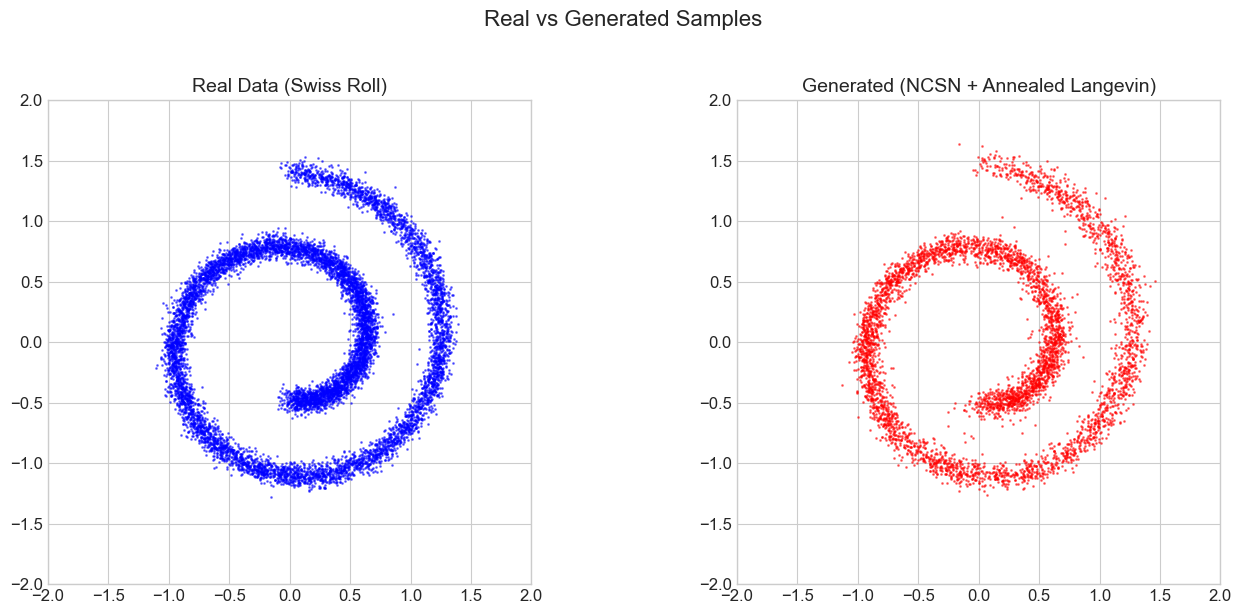

In [11]:
# Compare real and generated data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Real data
axes[0].scatter(X_train[:, 0], X_train[:, 1], s=1, alpha=0.5, c='blue')
axes[0].set_title('Real Data (Swiss Roll)', fontsize=14)
axes[0].set_xlim(-2, 2)
axes[0].set_ylim(-2, 2)
axes[0].set_aspect('equal')

# Generated data
axes[1].scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5, c='red')
axes[1].set_title('Generated (NCSN + Annealed Langevin)', fontsize=14)
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-2, 2)
axes[1].set_aspect('equal')

plt.suptitle('Real vs Generated Samples', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

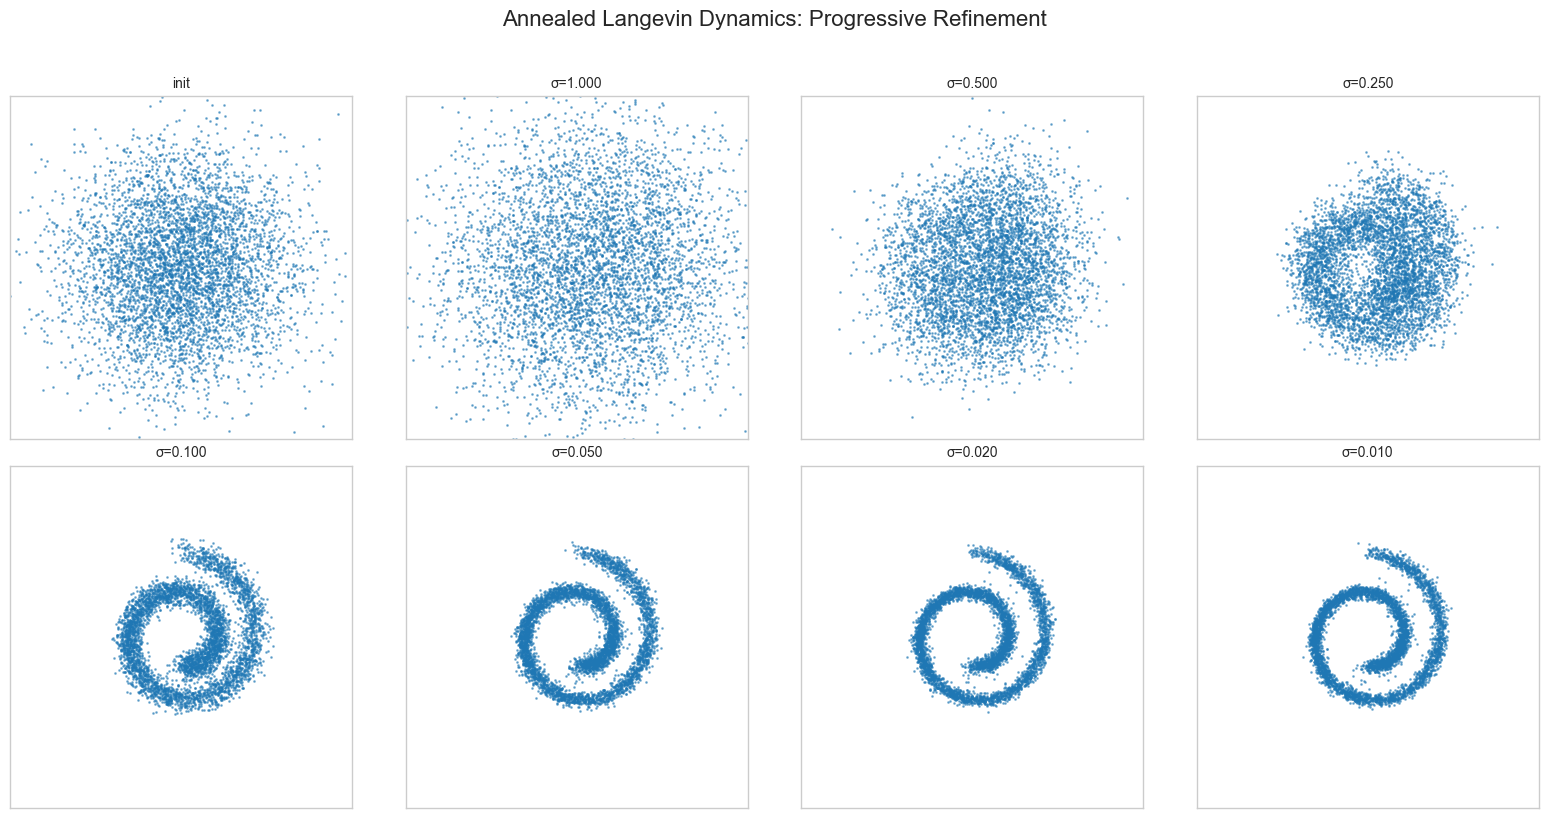

Observation: Samples start as noise and progressively sharpen into the Swiss roll!


In [12]:
# Visualize the annealing trajectory
n_show = len(trajectory)
n_cols = 4
n_rows = (n_show + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for idx, (data, label) in enumerate(trajectory):
    axes[idx].scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
    axes[idx].set_title(label, fontsize=10)
    axes[idx].set_xlim(-3, 3)
    axes[idx].set_ylim(-3, 3)
    axes[idx].set_aspect('equal')
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

# Hide unused axes
for idx in range(len(trajectory), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Annealed Langevin Dynamics: Progressive Refinement', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("Observation: Samples start as noise and progressively sharpen into the Swiss roll!")

## 9. Experiments and Analysis

### Effect of Number of Noise Levels (L)

In [13]:
def experiment_num_levels(L_values, data, epochs=100, device='cpu'):
    """
    Train models with different numbers of noise levels.
    """
    results = {}
    
    for L in L_values:
        print(f"\n{'='*50}")
        print(f"Training with L = {L} noise levels")
        print(f"{'='*50}")
        
        # Create geometric noise schedule
        sigmas_exp = geometric_noise_schedule(sigma_min=0.01, sigma_max=1.0, L=L)
        print(f"Sigmas: {sigmas_exp.numpy().round(3)}")
        
        # Create and train model
        m = NCSN(data_dim=2, hidden_dim=128).to(device)
        losses = train_ncsn(m, data, sigmas_exp, epochs=epochs, lr=1e-3, device=device)
        
        # Generate samples
        samples_exp = annealed_langevin_dynamics(
            m, sigmas_exp, n_samples=1000, steps_per_level=100, 
            step_size_factor=0.1, device=device
        )
        
        results[L] = {'model': m, 'sigmas': sigmas_exp, 'losses': losses, 'samples': samples_exp}
    
    return results

# Run experiment
L_values = [2, 5, 7, 10]
L_results = experiment_num_levels(L_values, X_train, epochs=100, device=device)


Training with L = 2 noise levels
Sigmas: [1.   0.01]
Epoch   1/100 | Loss: 9897.2034
Epoch  20/100 | Loss: 9916.3064
Epoch  40/100 | Loss: 9764.1327
Epoch  60/100 | Loss: 9888.8113
Epoch  80/100 | Loss: 9982.9611
Epoch 100/100 | Loss: 10144.6464

Training with L = 5 noise levels
Sigmas: [1.    0.316 0.1   0.032 0.01 ]
Epoch   1/100 | Loss: 4351.4385
Epoch  20/100 | Loss: 4360.6671
Epoch  40/100 | Loss: 4351.2334
Epoch  60/100 | Loss: 4310.3635
Epoch  80/100 | Loss: 4287.9166
Epoch 100/100 | Loss: 4418.6905

Training with L = 7 noise levels
Sigmas: [1.    0.464 0.215 0.1   0.046 0.022 0.01 ]
Epoch   1/100 | Loss: 3665.8400
Epoch  20/100 | Loss: 3675.5746
Epoch  40/100 | Loss: 3499.3310
Epoch  60/100 | Loss: 3456.6596
Epoch  80/100 | Loss: 3605.0405
Epoch 100/100 | Loss: 3233.9836

Training with L = 10 noise levels
Sigmas: [1.    0.599 0.359 0.215 0.129 0.077 0.046 0.028 0.017 0.01 ]
Epoch   1/100 | Loss: 3172.5415
Epoch  20/100 | Loss: 3104.6387
Epoch  40/100 | Loss: 3149.3419
Epoch  6

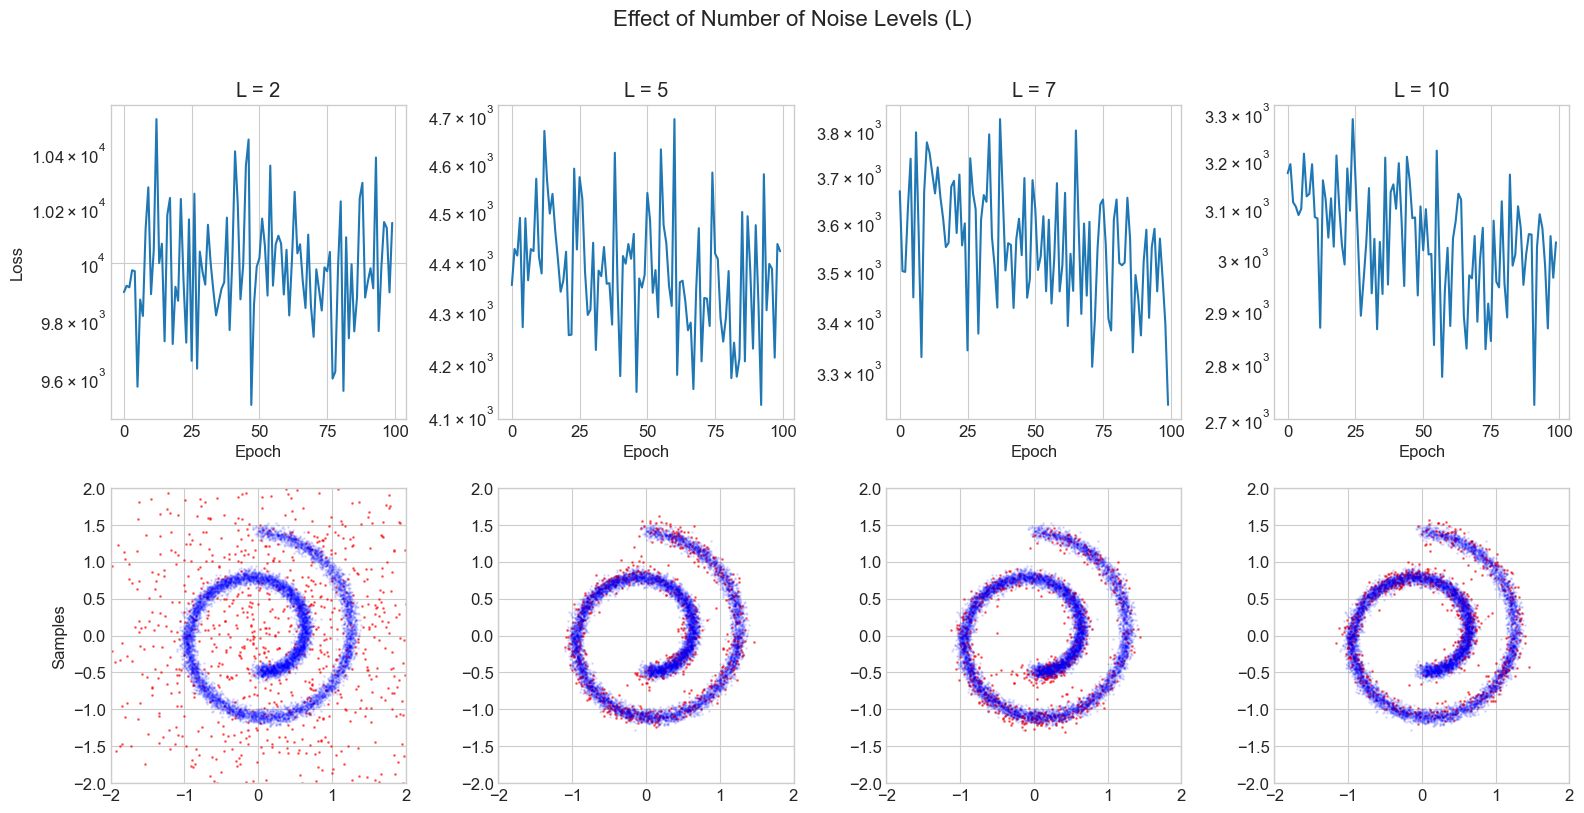


Observations:
- L=2: Too few levels, poor sample quality
- L=5-7: Good balance, captures structure well
- L=10: More levels can help, but diminishing returns


In [14]:
# Visualize results
fig, axes = plt.subplots(2, len(L_values), figsize=(16, 8))

for idx, L in enumerate(L_values):
    results = L_results[L]
    
    # Top row: Training loss
    axes[0, idx].plot(results['losses'])
    axes[0, idx].set_title(f'L = {L}')
    axes[0, idx].set_xlabel('Epoch')
    if idx == 0:
        axes[0, idx].set_ylabel('Loss')
    axes[0, idx].set_yscale('log')
    
    # Bottom row: Generated samples
    axes[1, idx].scatter(results['samples'][:, 0], results['samples'][:, 1], 
                         s=1, alpha=0.5, c='red')
    axes[1, idx].scatter(X_train[:, 0], X_train[:, 1], 
                         s=1, alpha=0.1, c='blue')
    axes[1, idx].set_xlim(-2, 2)
    axes[1, idx].set_ylim(-2, 2)
    axes[1, idx].set_aspect('equal')
    if idx == 0:
        axes[1, idx].set_ylabel('Samples')

plt.suptitle('Effect of Number of Noise Levels (L)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("- L=2: Too few levels, poor sample quality")
print("- L=5-7: Good balance, captures structure well")
print("- L=10: More levels can help, but diminishing returns")

### Comparison: Single-Noise DSM vs NCSN

In [15]:
# Train a single-noise DSM model for comparison
class SingleNoiseScoreNetwork(nn.Module):
    """Single-noise DSM model (no sigma conditioning)."""
    def __init__(self, data_dim=2, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(data_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, data_dim)
        )
    
    def forward(self, x):
        return self.net(x)


def train_single_noise_dsm(model, data, sigma, epochs=100, batch_size=128, lr=1e-3, device='cpu'):
    """Train single-noise DSM using epochs."""
    dataset = TensorDataset(torch.from_numpy(data))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(epochs):
        for (x,) in dataloader:
            x = x.to(device)
            
            noise = torch.randn_like(x) * sigma
            x_noisy = x + noise
            
            target_score = -noise / (sigma ** 2)
            pred_score = model(x_noisy)
            
            loss = ((pred_score - target_score) ** 2).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f"  Epoch {epoch+1}/{epochs}")
    
    return model


@torch.no_grad()
def langevin_single_noise(model, n_samples, n_steps, step_size, init_std=1.0, device='cpu'):
    """Langevin dynamics for single-noise DSM."""
    model.eval()
    x = init_std * torch.randn(n_samples, 2, device=device)
    for _ in range(n_steps):
        score = model(x)
        noise = torch.randn_like(x)
        x = x + step_size * score + np.sqrt(2 * step_size) * noise
    return x.cpu().numpy()


# Train single-noise models at different sigma
single_noise_sigmas = [0.1, 0.3, 0.5]
single_noise_results = {}

for sigma in single_noise_sigmas:
    print(f"\nTraining single-noise DSM with σ = {sigma}")
    m = SingleNoiseScoreNetwork(data_dim=2, hidden_dim=128).to(device)
    train_single_noise_dsm(m, X_train, sigma, epochs=100, lr=1e-3, device=device)
    samples_single = langevin_single_noise(m, n_samples=1000, n_steps=1000, 
                                           step_size=0.01 * sigma**2, init_std=1.0, device=device)
    single_noise_results[sigma] = samples_single


Training single-noise DSM with σ = 0.1
  Epoch 50/100
  Epoch 100/100

Training single-noise DSM with σ = 0.3
  Epoch 50/100
  Epoch 100/100

Training single-noise DSM with σ = 0.5
  Epoch 50/100
  Epoch 100/100


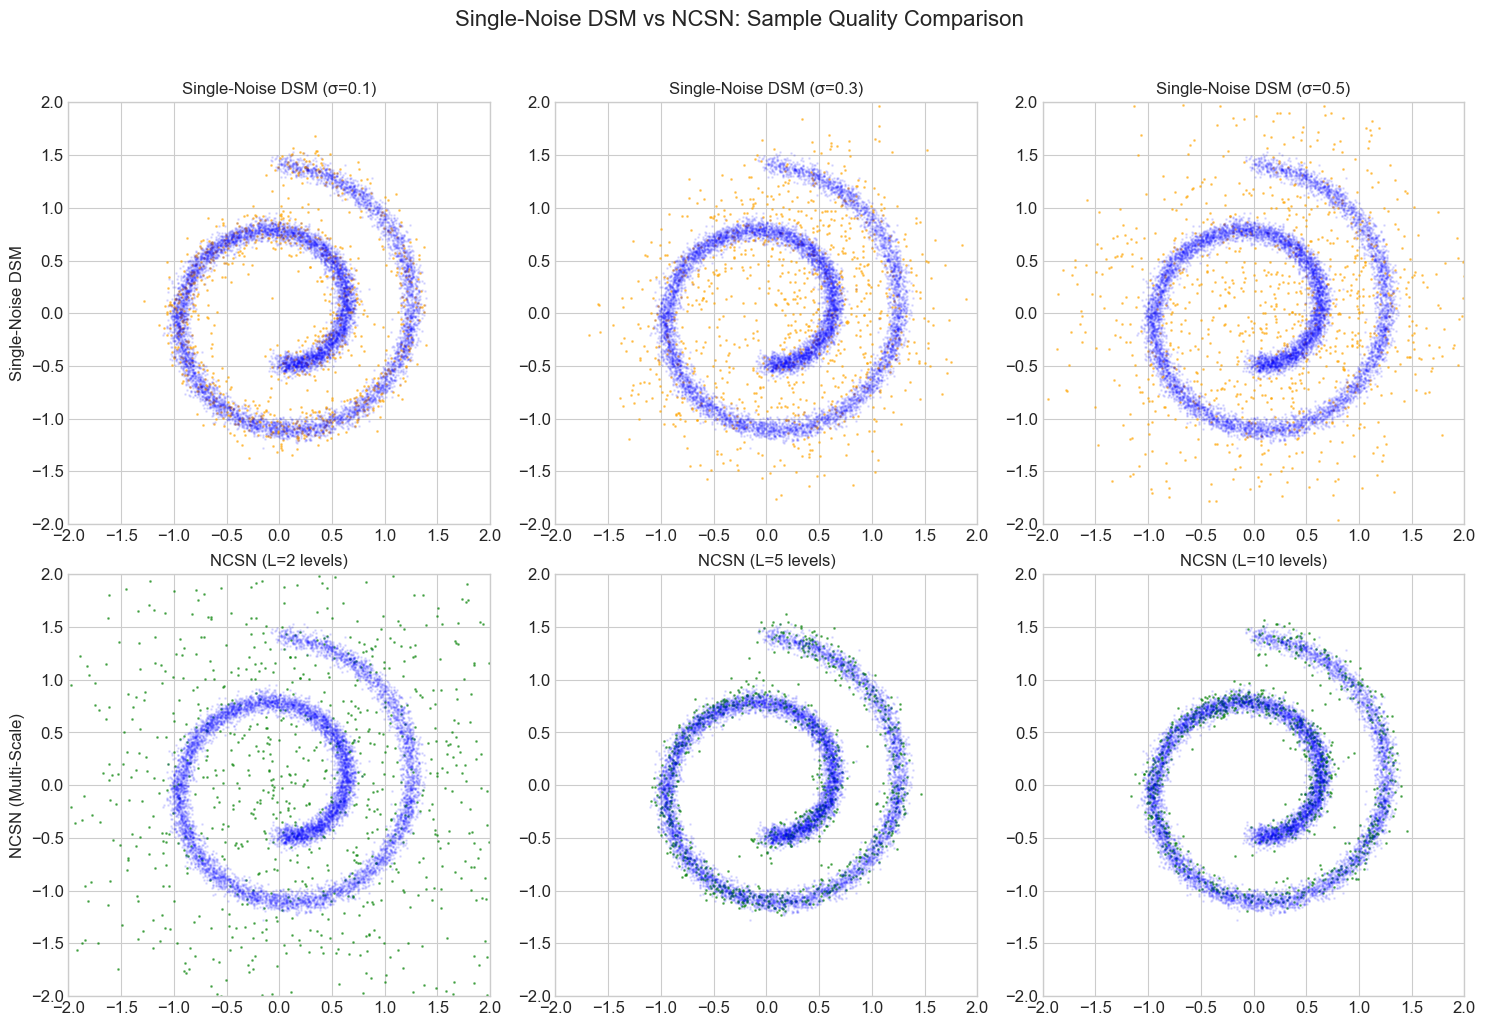


Key Observations:
- Single-noise DSM struggles with the coverage/accuracy trade-off
- NCSN achieves better sample quality by using multiple noise levels
- Annealing allows global structure (large σ) AND local detail (small σ)


In [16]:
# Comparison plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Top row: Single-noise DSM at different sigma
for idx, sigma in enumerate(single_noise_sigmas):
    axes[0, idx].scatter(single_noise_results[sigma][:, 0], single_noise_results[sigma][:, 1], 
                         s=1, alpha=0.5, c='orange')
    axes[0, idx].scatter(X_train[:, 0], X_train[:, 1], s=1, alpha=0.1, c='blue')
    axes[0, idx].set_title(f'Single-Noise DSM (σ={sigma})', fontsize=12)
    axes[0, idx].set_xlim(-2, 2)
    axes[0, idx].set_ylim(-2, 2)
    axes[0, idx].set_aspect('equal')

# Bottom row: NCSN with different L
L_to_show = [2, 5, 10]
for idx, L in enumerate(L_to_show):
    if L in L_results:
        axes[1, idx].scatter(L_results[L]['samples'][:, 0], L_results[L]['samples'][:, 1], 
                             s=1, alpha=0.5, c='green')
    axes[1, idx].scatter(X_train[:, 0], X_train[:, 1], s=1, alpha=0.1, c='blue')
    axes[1, idx].set_title(f'NCSN (L={L} levels)', fontsize=12)
    axes[1, idx].set_xlim(-2, 2)
    axes[1, idx].set_ylim(-2, 2)
    axes[1, idx].set_aspect('equal')

axes[0, 0].set_ylabel('Single-Noise DSM', fontsize=12)
axes[1, 0].set_ylabel('NCSN (Multi-Scale)', fontsize=12)

plt.suptitle('Single-Noise DSM vs NCSN: Sample Quality Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- Single-noise DSM struggles with the coverage/accuracy trade-off")
print("- NCSN achieves better sample quality by using multiple noise levels")
print("- Annealing allows global structure (large σ) AND local detail (small σ)")

## 10. Connection to Score SDE and DDPM

### The Unified View

NCSN, DDPM, and Score SDE are all fundamentally the same idea with different parameterizations:

| Model | Noise Levels | Score Parameterization | Sampling |
|-------|-------------|----------------------|----------|
| Single DSM | 1 | $s_\theta(x)$ | Langevin |
| NCSN | L discrete | $s_\theta(x, \sigma)$ | Annealed Langevin |
| DDPM | T discrete | $\epsilon_\theta(x_t, t)$ → $s = -\epsilon/\sqrt{1-\bar{\alpha}_t}$ | Ancestral |
| Score SDE | Continuous | $s_\theta(x, t)$ | Reverse SDE |

### From NCSN to Score SDE

As $L \to \infty$, the discrete noise levels become a continuous process:

$$dx = f(x, t) dt + g(t) dw$$

The reverse process (for sampling) is:

$$dx = [f(x, t) - g(t)^2 \nabla_x \log p_t(x)] dt + g(t) d\bar{w}$$

### From NCSN to DDPM

DDPM can be viewed as NCSN with:
- Specific noise schedule: $\sigma_t = \sqrt{1 - \bar{\alpha}_t}$
- Noise prediction instead of score: $\epsilon_\theta = -\sigma_t \cdot s_\theta$
- Ancestral sampling instead of Langevin

**Key insight:** They're all learning the same thing — the score function at different noise levels!

In [17]:
# Demonstrate the equivalence: score prediction vs noise prediction
print("Demonstration: Score ↔ Noise Prediction Equivalence")
print("="*50)

# Take a sample and add noise
x_0 = torch.tensor([[0.5, 0.5]], device=device)
sigma = 0.3
epsilon = torch.randn_like(x_0)
x_noisy = x_0 + sigma * epsilon

# The true score is -epsilon/sigma
true_score = -epsilon / sigma

# From noise to score: s = -ε/σ
score_from_noise = -epsilon / sigma

# From score to noise: ε = -σ·s
noise_from_score = -sigma * true_score

print(f"True noise ε:        {epsilon.cpu().numpy()}")
print(f"Noise from score:    {noise_from_score.cpu().numpy()}")
print(f"Match: {torch.allclose(epsilon, noise_from_score)}")
print()
print(f"True score s:        {true_score.cpu().numpy()}")
print(f"Score from noise:    {score_from_noise.cpu().numpy()}")
print(f"Match: {torch.allclose(true_score, score_from_noise)}")
print()
print("Conclusion: DDPM (noise prediction) and NCSN (score prediction) are equivalent!")

Demonstration: Score ↔ Noise Prediction Equivalence
True noise ε:        [[0.542911   0.07613066]]
Noise from score:    [[0.542911   0.07613066]]
Match: True

True score s:        [[-1.8097032  -0.25376886]]
Score from noise:    [[-1.8097032  -0.25376886]]
Match: True

Conclusion: DDPM (noise prediction) and NCSN (score prediction) are equivalent!
